In [3]:
'''
I want to create a model where you can input data like age, gender, etc., and I will then be
able to give a prediction of what kind of ultra runner that you would be.

1. I want to display two figures that show a distribution line where y is the probability that you
will enter a race of x length, for both types of races, run for the fastest time and most distance.
2. I also want to show how many races this person would likely complete, again with a distribution line.
3. I also want to show a distribution showing the likelihood that a person would get 1st, 2nd... 14th, 15th place in a race.

I think that I want to make it so people can move a slider for distance and it will show probability distributions for the above, based on that race length

independent variables: age, gender
dependent variables: victoriousness, average race length, amount of races completed, 
'''

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm

pd.set_option('display.float_format', '{:.2f}'.format)

df = pd.read_csv('../data/ultra_marathons_data_cleaned.csv', low_memory = False)
df.drop(['age_category', 'average_speed', 'no_of_finishers', 'athlete_country', 'athlete_club','start_date', 'end_date'], axis = 1, inplace = True)
df.head()

,year_of_event,event_name,distance_or_length,total_distance,birth_year,gender,athlete_id,race_metric,fastest_time
0,2018,Selva Costera (CHI),31.07,0.00,1978,M,0,mi,4:51:39
1,2018,Selva Costera (CHI),31.07,0.00,1981,M,1,mi,5:15:45
2,2018,Selva Costera (CHI),31.07,0.00,1987,M,2,mi,5:16:44
3,2018,Selva Costera (CHI),31.07,0.00,1976,M,3,mi,5:34:13
4,2018,Selva Costera (CHI),31.07,0.00,1992,M,4,mi,5:54:14


In [4]:
df['place'] = np.nan

def sort_and_place(group, metric):
    if metric == 'mi':
        group = group.sort_values(by = 'fastest_time', ascending = True)
    elif metric == 'hours':
        group = group.sort_values(by = 'distance_or_length', ascending = False)
    group['place'] = np.arange(1, len(group) + 1, dtype = int)
    return group

for metric in tqdm(['mi', 'hours']):
    grouped_df = df.groupby('event_name', as_index = False).apply(lambda group: sort_and_place(group, metric))
    grouped_df.reset_index(drop = True, inplace = True)
    df.update(grouped_df)

df.sample(10)

  0%|          | 0/2 [00:00<?, ?it/s]

,year_of_event,event_name,distance_or_length,total_distance,birth_year,gender,athlete_id,race_metric,fastest_time,place
6155331,2018,Trail du Haut Clunysois - Le Maratrail (FRA),32.31,0.00,1980,M,310995,mi,7:24:03,18.00
4035366,2015,Monschau-Ultra Marathon (GER),34.80,0.00,1972,F,477393,mi,6:27:15,189.00
200050,1978,"100 km del Passatore, Firenze-Faenza (ITA)",62.14,0.00,1932,M,1545920,mi,12:08:08,28283.00
4793631,2021,Risinge Backyard Ultra (SWE),15.00,53.65,1983,M,298148,hours,0,61.00
4535483,2022,Penyagolosa Trail MiM (ESP),37.28,0.00,1987,M,209744,mi,7:23:08,129.00
2239603,2013,Glasgow-Edinburgh Ultramarathon (GBR),55.00,0.00,1965,F,85707,mi,11:47:18,806.00
2612755,2015,Harzquerung Wernigerode-Nordhausen (GER),31.69,0.00,1971,F,278797,mi,6:08:09,1426.00
3824620,2019,MSIG Sai Kung 50 (HKG),31.07,0.00,1974,M,348585,mi,8:45:31,119.00
3284177,2008,La SainteLyon 69 km (FRA),42.87,0.00,1965,M,284659,mi,11:29:03,7384.00
588536,2018,Another One Bites the Dust (BEL),31.00,95.34,1988,M,101905,hours,0,133.00


In [5]:
df['age'] = df['year_of_event'] - df['birth_year']
# df.drop(['year_of_event', 'birth_year'], axis = 1, inplace = True)
df.head()

,year_of_event,event_name,distance_or_length,total_distance,birth_year,gender,athlete_id,race_metric,fastest_time,place,age
0,2019,#RC87 Sportparkchallenge (BEL),6.00,75.85,1978,M,64633,hours,0,1.00,41
1,2019,#RC87 Sportparkchallenge (BEL),6.00,56.38,1975,M,64706,hours,0,2.00,44
2,2019,#RC87 Sportparkchallenge (BEL),6.00,53.30,1966,M,64705,hours,0,3.00,53
3,2019,#RC87 Sportparkchallenge (BEL),6.00,69.70,1966,M,28518,hours,0,4.00,53
4,2019,#RC87 Sportparkchallenge (BEL),6.00,65.60,1978,M,64647,hours,0,5.00,41


In [6]:
df_hours = df[(df['race_metric'] == 'hours') & (df['age'] > 12) & (df['age'] < 100)].copy().drop('race_metric', axis = 1)
df_miles = df[(df['race_metric'] == 'mi') & (df['age'] > 12) & (df['age'] < 100)].copy().drop('race_metric', axis = 1)

In [7]:
df_miles = df_miles[pd.to_timedelta(df_miles['fastest_time']) > pd.to_timedelta(1, unit = 'h')]
df_miles['fastest_time'] = df_miles.apply(lambda row: int(pd.to_timedelta(row['fastest_time']).total_seconds()), axis = 1)
df_miles.describe()

,year_of_event,distance_or_length,total_distance,birth_year,athlete_id,fastest_time,place,age
count,6383624.00,6383624.00,6383624.00,6383624.00,6383624.00,6383624.00,6383624.00,6383624.00
mean,2012.08,45.51,0.00,1969.92,527485.56,43519.46,16729.32,42.16
std,9.77,35.90,0.00,13.07,467877.46,40054.66,43568.09,9.86
min,1837.00,0.00,0.00,1791.00,0.00,3615.00,1.00,13.00
25%,2010.00,31.07,0.00,1962.00,129856.00,24464.00,181.00,35.00
50%,2015.00,38.53,0.00,1971.00,370783.50,34464.00,818.00,42.00
75%,2018.00,55.92,0.00,1979.00,942810.00,47741.00,5130.00,49.00
max,2022.00,3554.00,0.00,2009.00,1641167.00,3020399.00,263574.00,99.00


In [8]:
df_miles.drop(['year_of_event', 'total_distance', 'birth_year', 'athlete_id', 'event_name', ], axis = 1, inplace = True)
df_hours.drop(['year_of_event', 'total_distance', 'birth_year', 'athlete_id', 'event_name'], axis = 1, inplace = True)

In [9]:
df_miles

,distance_or_length,gender,fastest_time,place,age
19,100.00,M,82385,1.00,39
20,100.00,M,82385,2.00,43
21,100.00,M,97920,3.00,36
22,100.00,M,97923,4.00,46
23,100.00,M,100380,5.00,57
...,...,...,...,...,...
7461189,50.00,M,30754,7.00,36
7461190,40.00,M,16604,1.00,37
7461191,40.00,M,16729,2.00,28
7461193,40.00,M,28650,4.00,41


In [10]:
df_miles[['age', 'gender', 'place', 'distance_or_length']].isnull().sum()

age                   0
gender                0
place                 0
distance_or_length    0
dtype: int64

In [11]:
# Most miles races

df_hours = df_hours[df_hours['gender'].isin(['M', 'F'])]
x_h = df_hours[['age', 'gender']]
x_h['gender'] = x_h['gender'].map({'M': 0, 'F': 1})
y_h = df_hours[['distance_or_length', 'place']]

x_train_h, x_test_h, y_train_h, y_test_h = train_test_split(x_h, y_h, train_size = 0.1)
hour_model = LinearRegression()

# Fastest time races
df_miles = df_miles[df_miles['gender'].isin(['M', 'F'])]
x_t = df_miles[['age', 'gender']]

x_t['gender'] = x_t['gender'].map({'M': 0, 'F': 1})
y_t = df_miles[['distance_or_length', 'place']]

x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(x_t, y_t, train_size = 0.1)
mile_model = LinearRegression()

C:\Users\OMEN\AppData\Local\Temp\ipykernel_8008\1052464175.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_h['gender'] = x_h['gender'].map({'M': 0, 'F': 1})
C:\Users\OMEN\AppData\Local\Temp\ipykernel_8008\1052464175.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_t['gender'] = x_t['gender'].map({'M': 0, 'F': 1})


In [12]:
hour_model.fit(x_train_h, y_train_h)
mile_model.fit(x_train_t, y_train_t)

LinearRegression()

In [13]:
yt_pred = mile_model.predict(x_test_t)
(yt_pred == y_test_t).sum()

distance_or_length    0
place                 0
dtype: int64

In [14]:
yh_pred = hour_model.predict(x_test_h)
(yh_pred == y_test_h).sum()

distance_or_length    0
place                 0
dtype: int64

In [15]:
mse_h = mean_squared_error(y_test_h, yh_pred)
r2_h = r2_score(y_test_h, yh_pred)

print(f"Mean Squared Error: {mse_h}")
print(f"R^2 Score: {r2_h}")

Mean Squared Error: 101585.81939412843
R^2 Score: 0.001753847212745241


In [16]:
mse_t = mean_squared_error(y_test_t, yt_pred)
r2_t = r2_score(y_test_t, yt_pred)

print(f"Mean Squared Error: {mse_t}")
print(f"R^2 Score: {r2_t}")

Mean Squared Error: 943117085.9689136
R^2 Score: 0.004228263543818944


In [28]:
dfc = df.copy()
dfc['gender'] = dfc['gender'].astype('category').cat.codes
filtered_df = dfc[
    (dfc['age'] == 30) &
    (dfc['gender'] == 0) &
    (dfc['distance_or_length'] == 100) &
    (dfc['place'] < 100)
]
prob_dist = filtered_df['place'].value_counts(normalize = True)

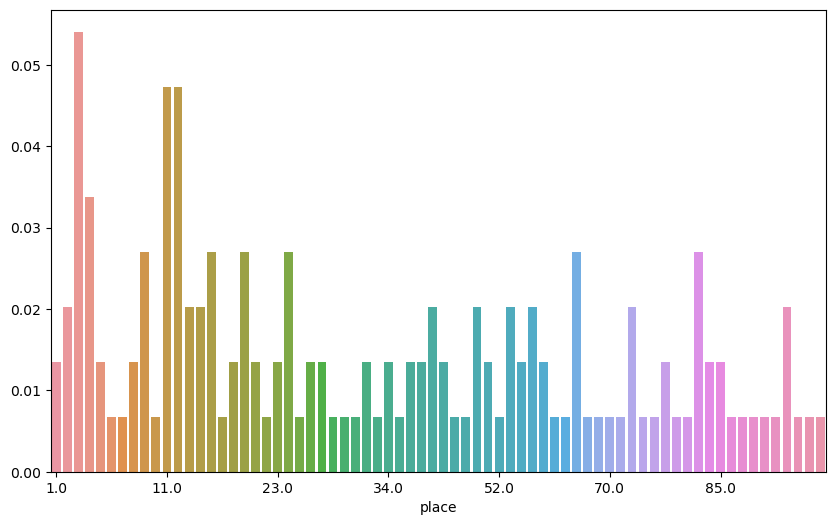

In [29]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

prob_dist = prob_dist.sort_index()

plt.figure(figsize = (10, 6))
sns.barplot(x=prob_dist.index, y = prob_dist.values)
ax = plt.gca()

ax.xaxis.set_major_locator(MaxNLocator(nbins = 8))